# multi-class classification of animals using tensorflow

In [49]:
import tensorflow as tf
import tensorflow_hub as hub
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from IPython.display import Image # view images
import datetime
import os

from sklearn.model_selection import train_test_split
from matplotlib.pyplot import imread  #read images as array of RGB values

1. Find filenames and path 

In [50]:
# import os
# Path = 'path_of_root'
# dataframe = pd.DataFrame()

# for subfolder in os.listdir(Path):
#     files = os.listdir(Path + subfolder)
#     for file in files:
#         if os.path.isfile(os.path.join(Path + subfolder, file)):
#             file_path = os.path.join(animals_path + subfolder, file)
#             file_name = os.path.splitext(os.path.basename(file_path))
#             Path = os.path.splitext(os.path.basename(file_path))[0]
#             x = [[file_path, file_name, subfolder,Path]]
#             x=pd.DataFrame(x)
#             dataframe = pd.concat([dataframe, x])
# dataframe = dataframe.drop(columns=[3])
# dataframe = dataframe.set_axis(['path', 'filename', 'kind'], axis='columns')
#
# dataframe["filname"]= dataframe["filname"].str.slice(2,-2)
# dataframe
# #dataframe.to_csv("labels.csv")

<Axes: xlabel='kind'>

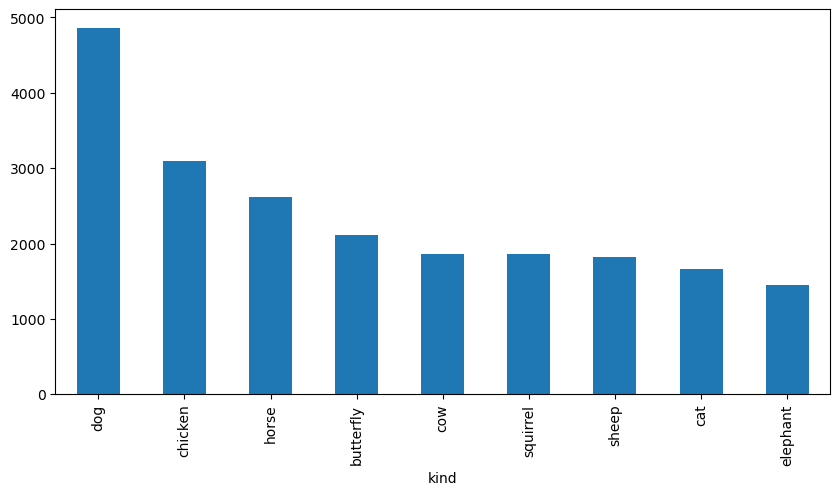

In [51]:
data =pd.read_csv('labels.csv')
data['kind'].value_counts().plot.bar(figsize=(10,5))

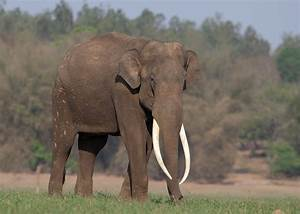

In [52]:
total_images = 21358
Image(data["path"].iloc[15000])


get labels

In [53]:
labels= np.array(data["kind"])
labels

array(['butterfly', 'butterfly', 'butterfly', ..., 'squirrel', 'squirrel',
       'squirrel'], dtype=object)

In [54]:
un_labels= np.unique(labels)
un_labels

array(['butterfly', 'cat', 'chicken', 'cow', 'dog', 'elephant', 'horse',
       'sheep', 'squirrel'], dtype=object)

3. convert to numeric values

In [55]:
mapping = {'butterfly': 0, 'cat': 1, 'chicken': 2, 'cow': 3, 'dog': 4, 'elephant': 5, 'horse': 6, 'sheep': 7, 'squirrel': 8}
key_map= {0:'butterfly', 1:'cat', 2:'chicken', 3:'cow', 4:'dog', 5:'elephant',6:'horse',7: 'sheep', 8:'squirrel'}
num_labels = np.vectorize(mapping.get)(labels)
type(num_labels)

numpy.ndarray

In [56]:
X= data["path"]
y= num_labels
X

0        animal_img/butterfly\e030b20928e90021d85a5854e...
1        animal_img/butterfly\e030b20929e90021d85a5854e...
2        animal_img/butterfly\e030b2092be90021d85a5854e...
3        animal_img/butterfly\e030b2092ce90021d85a5854e...
4        animal_img/butterfly\e030b2092de90021d85a5854e...
                               ...                        
21353    animal_img/squirrel\OIP-_U7JiIoYjbWPqmmmmdsvJw...
21354    animal_img/squirrel\OIP-_VBkNQd_MZI4xoemUb-FtA...
21355    animal_img/squirrel\OIP-_WyHKgREia-4VijlL6DNsw...
21356    animal_img/squirrel\OIP-_xFGMN0UbYduHdiXQ1maZA...
21357    animal_img/squirrel\OIP-_XkUFCI2duAyKDD9utKQzg...
Name: path, Length: 21358, dtype: object

In [57]:
y

array([0, 0, 0, ..., 8, 8, 8])

4. # Need to create a validation set to save time

In [58]:
NUM_IMAGES= 1000 # @param {type:"slider",min:1000,max:10000,step:100} # in colab        ## to train for a subset of 1000
# capital variables generally mean hyper_parameters

total_samples = len(X)

# Generate random indices to select 1000 images
random_indices = np.random.choice(total_samples, NUM_IMAGES, replace=False)

# Select the corresponding image paths from X and labels from y
subset_X = X.iloc[random_indices]   
subset_y = y[random_indices]

def custom_train_test_split(X, y, test_size=0.2, random_state=None):
    # Split the data into training and testing subsets
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=test_size, random_state=random_state)

    return X_train, X_test, y_train, y_test

# Usage
X_train, X_val, y_train, y_val = custom_train_test_split(subset_X, subset_y, test_size=0.2, random_state=42)
len(X_train),len(y_train),len(y_val),len(X_val)

(800, 800, 200, 200)

### TURN DATA INTO TENSORS

* funtion to do that
1. take filespaths as inputs
2. read files using tensorflow
3. turn into tensors and Normalize them
4. resize tensors in (224,224)
5. return images

In [59]:
image = imread(data['path'][33])
image[:2],image.shape # h,w, color_channel   3-> RGB

(array([[[133,  88,  33],
         [133,  88,  33],
         [133,  88,  33],
         ...,
         [153, 104,  63],
         [153, 104,  63],
         [153, 104,  61]],
 
        [[133,  88,  33],
         [133,  88,  33],
         [133,  88,  33],
         ...,
         [153, 104,  63],
         [154, 105,  64],
         [153, 104,  63]]], dtype=uint8),
 (427, 640, 3))

In [60]:
tf.constant(image)[:2]  # convert numerical data to tensor


<tf.Tensor: shape=(2, 640, 3), dtype=uint8, numpy=
array([[[133,  88,  33],
        [133,  88,  33],
        [133,  88,  33],
        ...,
        [153, 104,  63],
        [153, 104,  63],
        [153, 104,  61]],

       [[133,  88,  33],
        [133,  88,  33],
        [133,  88,  33],
        ...,
        [153, 104,  63],
        [154, 105,  64],
        [153, 104,  63]]], dtype=uint8)>

In [61]:
IMG_SIZE=224

def process_img(Path,size=[IMG_SIZE,IMG_SIZE]):
    """convert image at some path to tensor"""
    img = tf.io.read_file(Path) #return a string representation of tensor object
    #turn into numeric with RGB values
    img= tf.image.decode_image(img,channels=3,expand_animations = False)  
    # if all images are same format use decode_png/jpeg instead as decode image doesnt return shape without using expand_animations = False
    #normalize i.e. convert from(0,255) to(0,1)
    img= tf.image.convert_image_dtype(img,tf.float32)  # convert_image_dtype scales values [0-1] if necessary
    #resize
    img= tf.image.resize(img,size) #resize
    return img

## tensorflow prefers data as batch (32 at a time) with tensors as data+label to be faster and not exhaust memory
<img src="batches.png">

In [62]:
def tuple_tensor(X,y):
    """create tuple of image and label"""
    img=process_img(X)
    return (img,y)

tuple_tensor(X[12000],y[12000])

(<tf.Tensor: shape=(224, 224, 3), dtype=float32, numpy=
 array([[[0.12016807, 0.18224792, 0.00976891],
         [0.08413866, 0.14296219, 0.        ],
         [0.08781513, 0.14331234, 0.00332633],
         ...,
         [0.34936956, 0.25500658, 0.13165212],
         [0.3043759 , 0.16939627, 0.0399146 ],
         [0.2751751 , 0.10920878, 0.        ]],
 
        [[0.11194009, 0.17196293, 0.00771191],
         [0.08666014, 0.14422293, 0.        ],
         [0.08856715, 0.14368835, 0.00542756],
         ...,
         [0.26644927, 0.17666472, 0.06321924],
         [0.3470874 , 0.21701814, 0.09014617],
         [0.34827587, 0.18974125, 0.06117912]],
 
        [[0.1031136 , 0.16042277, 0.00954132],
         [0.0881573 , 0.14347067, 0.00534081],
         [0.08795097, 0.14133857, 0.01422444],
         ...,
         [0.22068645, 0.13660003, 0.04384554],
         [0.4262908 , 0.30211315, 0.19039191],
         [0.43489403, 0.28749344, 0.16001928]],
 
        ...,
 
        [[0.40747848, 0.37610593

### create batches

In [63]:
BATCH_SIZE =32
def d_batch(X,y=None,batch_size=BATCH_SIZE,valid_data=False,test_data=False):
    """
    Create batches of data from image(X),label(y)
    Shuffle training data
    Accepts test data as well   
    """
    #if test_data
    if test_data:
        print("testbatch")
        data = tf.data.Dataset.from_tensor_slices((tf.constant(X)))   # convert to dataset
        data_batch = data.map(process_img).batch(BATCH_SIZE)  # combine consecutive elements into batches
        return data_batch
    
    elif valid_data: #no shuffle needed
        print("validbatch") 
        data = tf.data.Dataset.from_tensor_slices((tf.constant(X),tf.constant(y))) 
        data_batch = data.map(tuple_tensor).batch(BATCH_SIZE) 
        return data_batch
    
    else: #need shuffle
        print("trainbatch")
        data = tf.data.Dataset.from_tensor_slices((tf.constant(X),tf.constant(y))) 
        #shuffle paths
        data = data.shuffle(buffer_size=len(data))   # shuffle X values                   ### doesnt seem to be shuffling
        data = data.map(tuple_tensor)
        data_batch = data.batch(BATCH_SIZE) 
        return data_batch    

In [64]:
train_data = d_batch(X_train, y_train)
val_data = d_batch(X_val, y_val,valid_data=True)

trainbatch


validbatch


In [65]:
train_data.element_spec, val_data.element_spec # display components of data
# batch_size return none as it is flexible

((TensorSpec(shape=(None, 224, 224, 3), dtype=tf.float32, name=None),
  TensorSpec(shape=(None,), dtype=tf.int32, name=None)),
 (TensorSpec(shape=(None, 224, 224, 3), dtype=tf.float32, name=None),
  TensorSpec(shape=(None,), dtype=tf.int32, name=None)))

In [66]:
def show_batch(img,label):
    plt.figure(figsize=(10,10))
    for i in range(25):
        X=plt.subplot(5,5,i+1)
        
        plt.imshow(img[i])
        title = key_map.get(label[i], "Unknown")
        plt.title(title)
        plt.axis('off')

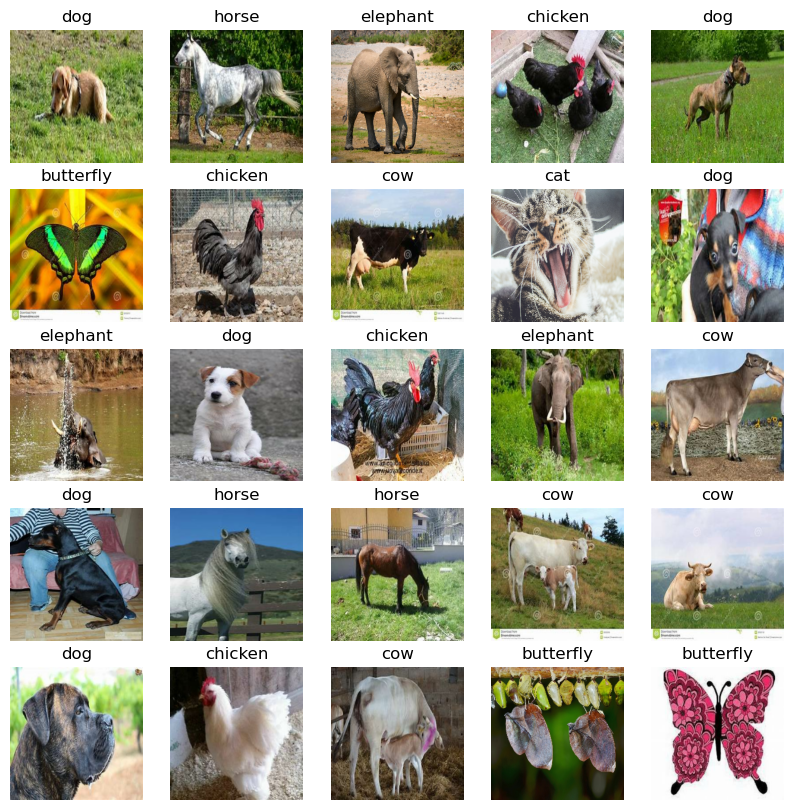

In [67]:
t_img, t_y =next(train_data.as_numpy_iterator()) # convert to an iterable
show_batch(t_img,t_y)

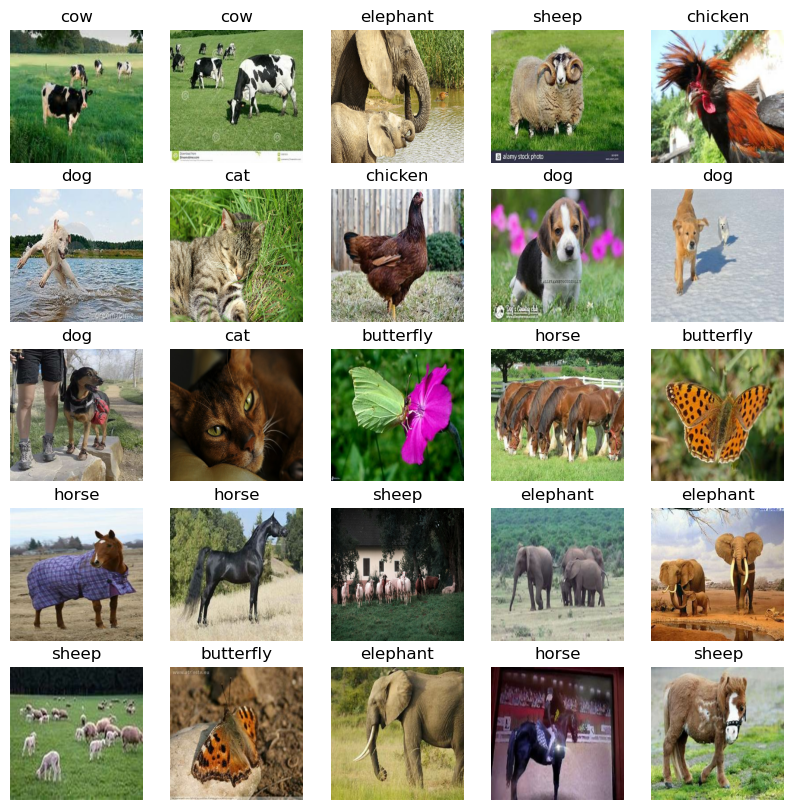

In [68]:
v_img,v_y=next(val_data.as_numpy_iterator())
show_batch(v_img,v_y)

## build model using existing model (transfer learning) from tensorflowhub

* define inputs
* define outputs
* build model / load existing model
https://tfhub.dev/google/imagenet/mobilenet_v2_140_224/classification/5

In [69]:
INPUT_SHAPE = [None,IMG_SIZE,IMG_SIZE,3]  # (batch_size,height,width,color_channel)
OUTPUT_SHAPE = len(un_labels) 

MODEL_URL = "https://tfhub.dev/google/imagenet/mobilenet_v2_140_224/classification/5"

# MobileNet is TensorFlow’s first mobile computer vision model.

#### It uses depthwise separable convolutions
####  to significantly reduce the number of parameters
#### compared to other networks with regular convolutions and the same depth in the nets. 
#### This results in lightweight deep neural networks.

* to build and train we can use tf.keras api

In [70]:
def create_model(input_shape=INPUT_SHAPE, output_shape=OUTPUT_SHAPE, model_url=MODEL_URL):
    """
    1.Takes input shape, OUTPUT_SHAPE, and MODEL_URL 
    2.defines layers of Neural Network
    3.compiles model
    4.builds model
    return model object
    "https://www.tensorflow.org/guide/keras/overview"
    """
    print("building model")
    model =tf.keras.Sequential([
        hub.KerasLayer(model_url), #input layer
        tf.keras.layers.Dense(units=OUTPUT_SHAPE,   # default shape of this model is 1,1,1280 , we need to specify output_shape
                              activation="softmax") ])# layer 2 output layer          # softmax activation function is normalized exponential function that takes vector of size K and return  
    # probability distribution (K outputs) who are proportional to Exp(input)    normalized to (0,1) sum of output Ks =1    
    model.compile(
        loss=tf.keras.losses.sparse_categorical_crossentropy,    # minimize loss / error.  
        # since labels are integers and not OH encoded otherwise loss function is categorical_crossentropy
        
        optimizer=tf.keras.optimizers.Adam(),   #      adam() is generally fast for most applications
        metrics=["accuracy"]
    )
    model.build(input_shape)  #  
    return model
    

<img src="functions.png" height=200>

In [71]:
# model = create_model()
# model.summary()

# non trainable refer to the parameters (patterns) that it was originally trained on. i.e. the original number of parameters

`layers in Image net model`

<img src="mobileNetV2Arch.png">

`each layer is a mini model`

# Create callbacks
`helper functions to check and save progress/ stop training if no longer improving`

In [72]:
def tensorboard_callbacks():
    """This callback logs events for TensorBoard, including:
    Metrics summary plots
    Training graph visualization
    Weight histograms
    Sampled profiling
    """
    # Create directory to store logs
    dir=os.path.join("logs/", datetime.datetime.now().strftime("%Y%m%d-%H%M%S"))
    return tf.keras.callbacks.TensorBoard(dir)


In [73]:
early_stop = tf.keras.callbacks.EarlyStopping(monitor="val_accuracy",patience=3)

# train on subset

In [74]:
NUM_EPOCHS= 100  # number of epochs (passes) of data
tf.config.list_physical_devices()

[PhysicalDevice(name='/physical_device:CPU:0', device_type='CPU')]

In [75]:
def train_model(num_epochs=NUM_EPOCHS):
    """train model and return trained model."""
    model=create_model()
    tensorboard=tensorboard_callbacks()
    model.fit(x=train_data, epochs=num_epochs, validation_data=val_data, validation_freq=1,callbacks=[tensorboard,early_stop])
    return model

In [76]:
#model = train_model()

In [77]:
%tensorboard --dir C:\Users\Haroon\Documents\VS-Code\py\TensorFlow_\logs

UsageError: Line magic function `%tensorboard` not found.


# predictions

In [78]:
#preds = model.predict(val_data, verbose =1)  # when predicting ignore actual labels, as val_data contains labels
#preds   # probabilities for each label

In [79]:
#preds.shape, preds[0], key_map[np.argmax(preds[0])]

(-0.5, 239.5, 159.5, -0.5)

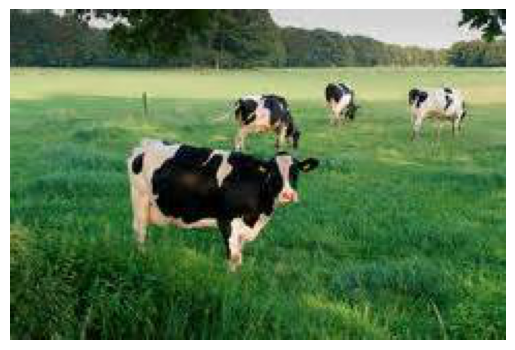

In [80]:
plt.imshow(plt.imread(X_val.iloc[0]))
plt.axis('off')


In [81]:
def pred_lab(pred_prob):
    """
    turn probability to label
    """
    return key_map[np.argmax(pred_prob)]

la = pred_lab(preds[5])

In [82]:
def unbatch(bat):
    """
    unbatch dataset of (image, label) tensor
    return array of image array of label
    """
    img_ = []
    lab_ = []
    for img,lab in bat.unbatch().as_numpy_iterator():
        img_.append(img)
        lab_.append(lab)
    return img_,lab_

val_img,val_lab = unbatch(val_data)
val_img,val_lab
    

([array([[[0.23599441, 0.2987395 , 0.24775912],
          [0.24481794, 0.30756304, 0.25658265],
          [0.17408963, 0.23683473, 0.18585433],
          ...,
          [0.04453783, 0.10728294, 0.06414568],
          [0.00462204, 0.04986022, 0.00672296],
          [0.        , 0.0582632 , 0.01134446]],
  
         [[0.23335336, 0.29609844, 0.24511807],
          [0.23449382, 0.29723892, 0.24625853],
          [0.18657462, 0.24931973, 0.19833933],
          ...,
          [0.07735095, 0.14009605, 0.09695879],
          [0.00822363, 0.05946418, 0.01832771],
          [0.        , 0.04121655, 0.0051821 ]],
  
         [[0.22316928, 0.2859144 , 0.23717488],
          [0.21086435, 0.27360946, 0.22486997],
          [0.19465788, 0.25740296, 0.20866348],
          ...,
          [0.10384158, 0.16658668, 0.12456987],
          [0.02080872, 0.07955224, 0.04203721],
          [0.00904364, 0.04839951, 0.01736706]],
  
         ...,
  
         [[0.19647938, 0.300681  , 0.1490603 ],
          [0.1

# VISUALIZATION

In [83]:
def plot_pred(pre_prob,label,image,n=1):
    """
    view prediction, image, and actual label of nth index
    """
    prob,truth,img = pre_prob[n],label[n],image[n]
    p_label = pred_lab(prob)
    plt.imshow(img)
    plt.axis("off")
    if(p_label==key_map[truth]):
        color = "green"
    else: 
        color = "red"
    plt.title('prediction : {} \n Confidence : {:.2f} \n actual : {}'.format(p_label,
                                                                             np.max(prob)*100,
                                                                             key_map[truth]),
              color=color)
    
#plot_pred(pre_prob=preds,label=val_lab,image=val_img,n=49)


In [84]:
def pred_conf(pred_probs,labels,n=1):
    """return top 3 predicted probabilities"""
    p_p,tr_l=pred_probs[n],labels[n]
    pre_lab = pred_lab(p_p)
    top_index= p_p.argsort()[-3:][::-1]
    top_val =  p_p[top_index]
    top_lab = un_labels[top_index]
    top_plot = plt.bar(np.arange(len(top_lab))
                       ,top_val,
                       color='grey')
    plt.xticks(np.arange(len(top_lab)),
               labels=top_lab,
               rotation='vertical')
    if key_map[tr_l] in top_lab:
        top_plot[np.argmax(top_lab==key_map[tr_l])].set_color('green')
    else:
        pass

In [85]:
#pred_conf(preds,val_lab,n=9)

In [86]:
# i_mul,rows,cols = 5,3,2
# num_img =rows*cols
# plt.figure(figsize=(10*cols,5*rows))

# for i in range(num_img):
#     plt.subplot(rows, 2 * cols, 2 * i + 1)
#     plot_pred(preds, val_lab, val_img, n=i + i_mul)
    
#     plt.subplot(rows, 2 * cols, 2 * i + 2)  # Add this line
#     pred_conf(preds, val_lab, n=i + i_mul)

# plt.show()

<Axes: >

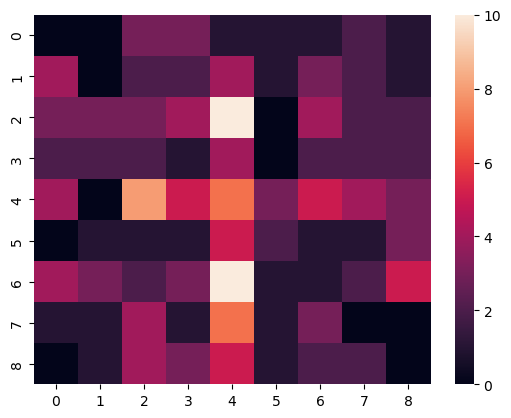

In [87]:
import seaborn as sns
cfm = tf.math.confusion_matrix(
    val_lab,
    np.argmax(preds, axis=1),            # seperate labels
)

sns.heatmap(cfm)

# save and reload

In [88]:
def save_model(model,suffix =None):
    """Save the model and append suffix"""
    dir= os.path.join("saved_models",datetime.datetime.now().strftime('%Y-%m-%d-%H-%M'))
    path =dir + "-" + ".h5"
    print("saving")
    model.save(path)  
    return(path)

def load_model(path):
    """return saved model from path"""
    print("loading")
    model = tf.keras.models.load_model(path,custom_objects={"KerasLayer":hub.KerasLayer})   # layers are custom
    return(model)    

In [89]:
#save_model(model,suffix ="1000-images-mobilenetv2-Adam")
#_model =load_model('saved_models\\2023-09-03-17-25-.h5')
#l_model.summary

In [90]:
#l_model.evaluate(val_data), model.evaluate(val_data)

# use full dataset

In [91]:
full_data =d_batch(X,y)
full_data

trainbatch


<BatchDataset element_spec=(TensorSpec(shape=(None, 224, 224, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None,), dtype=tf.int32, name=None))>

In [92]:
#full_model = create_model()

In [93]:
full_tensorboard  = tensorboard_callbacks()
full_early_stop = tf.keras.callbacks.EarlyStopping(monitor='accuracy',patience=3)

# `cell below will take time`

In [94]:
#full_model.fit(x=full_data,epochs=NUM_EPOCHS,callbacks=[full_tensorboard,full_early_stop])

In [95]:
full_l = load_model('saved_models\\2023-09-03-21-13-.h5')


loading
